In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.ticker as mtick


import seaborn as sns
import numpy as np
import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
import sys
sys.path.append('../')
from utils import *
from hashids import Hashids
with open('/home/em/togo/salt.txt', 'r') as saltfile:
    salt = saltfile.read().strip() # Very important to strip off any newline characters!
hashcode = Hashids(salt=salt, min_length=16)
spark = get_spark_session()
spark.sparkContext.addPyFile("/home/em/covid/dependencies/hashids.py")
sns.set(font_scale=2, style='white')

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()



### I. Plot unique MSISDN and IMEIs by day, remove outliers

In [146]:
toplevel_dir = '/data/togo_anon/feats/phone_sharing/december'
months = ['2020-12']

cols = ['caller_msisdn', 'operator', 'month', 'day', 'imei']
voice = spark.read.csv('/data/togo_anon/cdr/voice/2020/12.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])
sms = spark.read.csv('/data/togo_anon/cdr/sms/2020/12.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])
cdr = voice.union(sms)

In [147]:
msisdn_by_day = cdr.groupby('day').agg(countDistinct('caller_msisdn'))\
    .withColumnRenamed('count(caller_msisdn)', 'count')
save_df(msisdn_by_day, toplevel_dir + 'msisdn_by_day.csv')

imei_by_day = cdr.groupby('day').agg(countDistinct('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(imei_by_day, toplevel_dir + 'imei_by_day.csv')

In [148]:
msisdn_by_day = pd.read_csv(toplevel_dir + 'msisdn_by_day.csv')
msisdn_by_day['day'] = pd.to_datetime(msisdn_by_day['day'])
msisdn_by_day = msisdn_by_day.sort_values('day', ascending=True)

imei_by_day = pd.read_csv(toplevel_dir + 'imei_by_day.csv')
imei_by_day['day'] = pd.to_datetime(imei_by_day['day'])
imei_by_day = imei_by_day.sort_values('day', ascending=True)

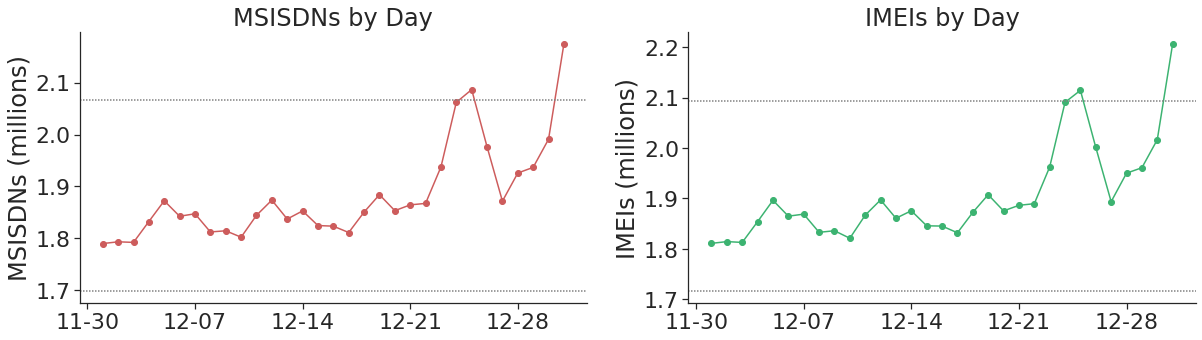

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(msisdn_by_day['day'], msisdn_by_day['count']/1000000, color='indianred')
ax[0].plot(msisdn_by_day['day'], msisdn_by_day['count']/1000000, color='indianred')
ax[0].set_title('MSISDNs by Day')
ax[0].set_ylabel('MSISDNs (millions)')
msisdn_sd_below = msisdn_by_day['count'].mean() - 2*msisdn_by_day['count'].std()
msisdn_sd_above = msisdn_by_day['count'].mean() + 2*msisdn_by_day['count'].std()
ax[0].axhline(msisdn_sd_above/1000000, color='grey', dashes=[1, 1])
ax[0].axhline(msisdn_sd_below/1000000, color='grey', dashes=[1, 1])

ax[1].scatter(imei_by_day['day'], imei_by_day['count']/1000000, color='mediumseagreen')
ax[1].plot(imei_by_day['day'], imei_by_day['count']/1000000, color='mediumseagreen')
ax[1].set_title('IMEIs by Day')
ax[1].set_ylabel('IMEIs (millions)')
imei_sd_below = imei_by_day['count'].mean() - 2*imei_by_day['count'].std()
imei_sd_above = imei_by_day['count'].mean() + 2*imei_by_day['count'].std()
ax[1].axhline(imei_sd_below/1000000, color='grey', dashes=[1, 1])
ax[1].axhline(imei_sd_above/1000000, color='grey', dashes=[1, 1])

locator = mdates.DayLocator(interval=7)
formatter = mdates.DateFormatter('%m-%d')
for a in range(len(ax)):
    ax[a].xaxis.set_major_locator(locator)
    ax[a].xaxis.set_major_formatter(formatter)
    simpleaxis(ax[a])

plt.show()

outliers_msisdn = list(msisdn_by_day[(msisdn_by_day['count'] < msisdn_sd_below) | \
                                     (msisdn_by_day['count'] > msisdn_sd_above)]['day'])
outliers_imei = list(msisdn_by_day[(msisdn_by_day['count'] < msisdn_sd_below) | \
                                   (msisdn_by_day['count'] > msisdn_sd_above)]['day'])
outliers = list(set([x.strftime('%Y-%m-%d') for x in outliers_msisdn + outliers_imei]))
pd.DataFrame(outliers, columns=['outliers']).to_csv(toplevel_dir + 'outliers.csv', index=False)

### II. Generate datasets of three outcomes: IMEI/MSISDN, MSISDN/IMEI, and Shared IMEI/MSISDN

In [167]:
toplevel_dir = '/data/togo_anon/feats/phone_sharing/november'
months = ['2020-11']

outliers = list(pd.read_csv(toplevel_dir + 'outliers.csv')['outliers'])
cols = ['caller_msisdn', 'operator', 'month', 'day', 'imei']
voice = spark.read.csv('/data/togo_anon/cdr/voice/2020/11.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])\
    .where(~(col('day').isin(outliers)))
sms = spark.read.csv('/data/togo_anon/cdr/sms/2020/11.csv', header=True)\
    .select(cols)\
    .where(col('month').isin(months))\
    .na.drop(subset=['caller_msisdn', 'month', 'day', 'imei'])\
    .where(~(col('day').isin(outliers)))
cdr = voice.union(sms)

In [168]:
imei_per_msisdn = cdr.groupby('caller_msisdn').agg(countDistinct('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(imei_per_msisdn, toplevel_dir + 'imei_per_msisdn.csv')

msisdn_per_imei = cdr.groupby('imei').agg(countDistinct('caller_msisdn'))\
    .withColumnRenamed('count(caller_msisdn)', 'count')
save_df(msisdn_per_imei, toplevel_dir + 'msisdn_per_imei.csv')


In [169]:
shared_imeis = msisdn_per_imei.withColumn('shared', col('count') > 1)
unique_msisdns = imei_per_msisdn.select('caller_msisdn')
shared_imei_per_msisdn = cdr.join(shared_imeis, on='imei', how='left')\
    .where(col('shared') == True)\
    .groupby('caller_msisdn').agg(countDistinct('imei'))\
    .join(unique_msisdns, on='caller_msisdn', how='right')\
    .fillna(0, subset=['count(imei)'])\
    .withColumnRenamed('count(imei)', 'count')

save_df(shared_imei_per_msisdn, toplevel_dir + 'shared_imei_per_msisdn.csv')

In [170]:
count_txns = cdr.groupby('caller_msisdn').agg(count('imei'))\
    .withColumnRenamed('count(imei)', 'count')
save_df(count_txns, toplevel_dir + 'count_transactions.csv')

### III. Get Table for Entire Network

In [108]:
toplevel_dir = '/data/togo_anon/feats/phone_sharing/january'

imei_per_msisdn = pd.read_csv(toplevel_dir + 'imei_per_msisdn.csv')
msisdn_per_imei = pd.read_csv(toplevel_dir + 'msisdn_per_imei.csv')
shared_imei_per_msisdn = pd.read_csv(toplevel_dir + 'shared_imei_per_msisdn.csv')
outcomes = [('imei_per_msisdn', imei_per_msisdn), 
            ('msisdn_per_imei', msisdn_per_imei), 
            ('shared_imei_per_msisdn', shared_imei_per_msisdn)]

/home/em/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
table = []
for label, outcome in outcomes:
    limit = 0 if label == 'shared_imei_per_msisdn' else 1
    column = ['%.2f (%.2f)' % (outcome['count'].mean(), outcome['count'].std()), 
              '%.2f'% outcome['count'].median(), 
              '%.2f' % outcome['count'].mode()[0], 
              '%.2f' % (100*(outcome['count'] > limit).mean()),
              '%i' % len(outcome)]
    table.append(column)

table = pd.DataFrame(table).T
table.columns = [label for label, _ in outcomes]
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,imei_per_msisdn,msisdn_per_imei,shared_imei_per_msisdn
Mean,1.31 (0.77),1.07 (1.57),0.16 (0.51)
Median,1.00,1.00,0.00
Mode,1.00,1.00,0.00
Share,20.06,6.18,12.24
N,4591728,5582337,4591728


### IV. Match to administrative data

In [2]:
novissi = pd.read_csv('/data/togo_anon/novissi/gd/registrations/2021-05-19.csv')\
    [['Gender', 'Age', 'Prefecture', 'Canton', 'RegistrationDate', 'PhoneNumber']]
novissi['RegistrationDate'] = pd.to_datetime(novissi['RegistrationDate'])
novissi = novissi[novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')]
novissi['rural'] = novissi['Prefecture'].apply(lambda x: 0 if x in ['GOLFE', 'AGOE-NYIVE', 'TCHAOUDJO'] else 1)

# Check registered November-December
novissi['registered_nov_dec'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                                 (novissi['RegistrationDate'] <= pd.to_datetime('2020-12-31')))\
                                .astype('int')
novissi['registered_nov'] = ((novissi['RegistrationDate'] >= pd.to_datetime('2020-11-01')) & \
                             (novissi['RegistrationDate'] <= pd.to_datetime('2020-11-30')))\
.astype('int')
print('Percent between November and December: %.2f' % (100*(novissi['registered_nov_dec'].mean())))

# Check in targeted canton
targeted_cantons = pd.read_csv('/data/togo_anon/satellite/selected_cantons_oct6.csv')\
    .rename({'novissi_prefecture_name':'Prefecture', 'novissi_canton_name':'Canton', 
             'targeted':'targeted_canton'}, axis=1)\
    [['targeted_canton', 'Prefecture', 'Canton']]
novissi = novissi.merge(targeted_cantons, on=['Prefecture', 'Canton'], how='left')
novissi['targeted_canton'] = novissi['targeted_canton'].fillna(0)
print('Percent in targeted cantons: %.2f' % (100*(novissi[novissi['registered_nov_dec'] == 1]['targeted_canton']\
                                                  .mean())))

# Check below wealth threshold
wealth_scores = pd.read_csv('/data/togo_anon/novissi/gd/whitelist/oldsims_p1_anon_info.csv')\
    .rename({'phone_number':'PhoneNumber', 'cdr_pmt':'poverty', 'treatment':'treated'}, axis=1)\
    [['PhoneNumber', 'poverty', 'treated']]
novissi = novissi.merge(wealth_scores, on='PhoneNumber', how='left')
novissi['below_wealth_threshold'] = (novissi['treated'] >= 0).astype('int')
print('Percent below wealth threshold: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                                             (novissi['targeted_canton'] == 1)]\
                                                     ['below_wealth_threshold'].mean())))
print('Percent treated: %.2f' % (100*(novissi[(novissi['registered_nov_dec'] == 1) & 
                                              (novissi['targeted_canton'] == 1) & 
                                              (novissi['below_wealth_threshold'] == 1)]\
                                                     ['treated'].mean())))

Percent between November and December: 97.97
Percent in targeted cantons: 87.42
Percent below wealth threshold: 32.73
Percent treated: 56.38


In [111]:
df = novissi.copy()
for label, outcome in outcomes:
    if label != 'msisdn_per_imei':
        data = outcome.rename({'caller_msisdn':'PhoneNumber', 'count':label}, axis=1)
        df = df.merge(data, on='PhoneNumber', how='inner')
        
counts = pd.read_csv(toplevel_dir + 'count_transactions.csv')\
    .rename({'caller_msisdn':'PhoneNumber', 'count':'count_txns'}, axis=1)
df = df.merge(counts, on='PhoneNumber', how='inner')

print('Percent with phone data: %.2f' % (100*len(df)/len(novissi)))

Percent with phone data: 80.06


In [112]:
table = []
for label, outcome in outcomes:
    limit = 0 if label == 'shared_imei_per_msisdn' else 1
    if label != 'msisdn_per_imei':
        column = ['%.2f (%.2f)' % (df[label].mean(), df[label].std()), 
                  '%.2f'% df[label].median(), 
                  '%.2f' % df[label].mode()[0], 
                  '%.2f' % (100*(df[label] > limit).mean()),
                  '%i' % len(df)]
        table.append(column)

table = pd.DataFrame(table).T
table.columns = [label for label, _ in outcomes if label != 'msisdn_per_imei']
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,imei_per_msisdn,shared_imei_per_msisdn
Mean,1.52 (1.02),0.27 (0.67)
Median,1.00,0.00
Mode,1.00,0.00
Share,30.13,18.65
N,140175,140175


In [113]:
df_rct = df[df['below_wealth_threshold'] == 1]
table = []
for label, outcome in outcomes:
    limit = 0 if label == 'shared_imei_per_msisdn' else 1
    if label != 'msisdn_per_imei':
        column = ['%.2f (%.2f)' % (df_rct[label].mean(), df_rct[label].std()), 
                  '%.2f'% df_rct[label].median(), 
                  '%.2f' % df_rct[label].mode()[0], 
                  '%.2f' % (100*(df_rct[label] > limit).mean()),
                  '%i' % len(df_rct)]
        table.append(column)

table = pd.DataFrame(table).T
table.columns = [label for label, _ in outcomes if label != 'msisdn_per_imei']
table.index = ['Mean', 'Median', 'Mode', 'Share', 'N']
table

,imei_per_msisdn,shared_imei_per_msisdn
Mean,1.48 (0.97),0.23 (0.62)
Median,1.00,0.00
Mode,1.00,0.00
Share,28.67,16.67
N,47482,47482


### Heterogeneity Analyses

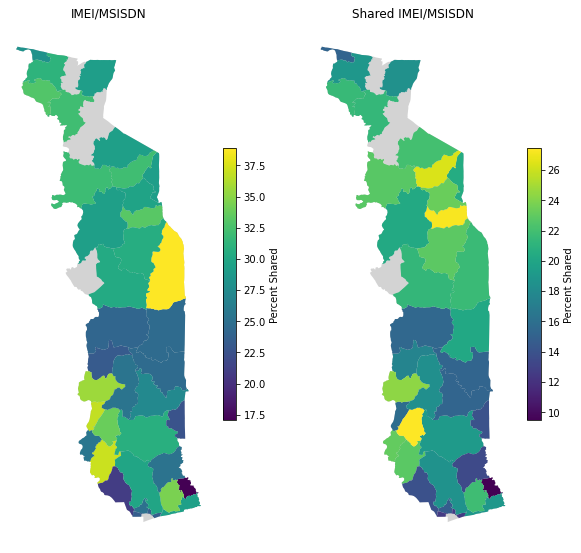

In [84]:
data = df.copy()
data['imei_per_msisdn'] = 100*(data['imei_per_msisdn'] > 1).astype('int')
data['shared_imei_per_msisdn'] = 100*(data['shared_imei_per_msisdn'] > 0).astype('int')

pop = data.groupby('Prefecture', as_index=False).agg('count')[['Prefecture', 'Gender']]\
    .rename({'Gender':'count'}, axis=1)
pop = pop[pop['count'] > 10]
avg = data.groupby('Prefecture', as_index=False).agg('mean')
avg = pop.merge(avg, on='Prefecture')
shapefile = gpd.read_file('/home/em/covid/spatial/prefectures.geojson')[['PREFECTURE', 'geometry']]\
    .rename({'PREFECTURE':'Prefecture'}, axis=1)
avg = shapefile.merge(avg, on='Prefecture', how='inner')

sns.reset_orig()
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1%}'.format(x)
#cbar = plt.colorbar(format=FuncFormatter(fmt))
shapefile.plot(ax=ax[0], color='lightgrey',)
avg.plot(ax=ax[0], column=['imei_per_msisdn'], legend=True, 
         legend_kwds={'label': 'Percent Shared', 'shrink':0.5})

shapefile.plot(ax=ax[1], color='lightgrey')
avg.plot(ax=ax[1], column=['shared_imei_per_msisdn'], legend=True,
        legend_kwds={'label': 'Percent Shared', 'shrink':0.5})

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('IMEI/MSISDN')
ax[1].set_title('Shared IMEI/MSISDN')
plt.savefig('/home/em/sharing1.png', dpi=300)
plt.show()

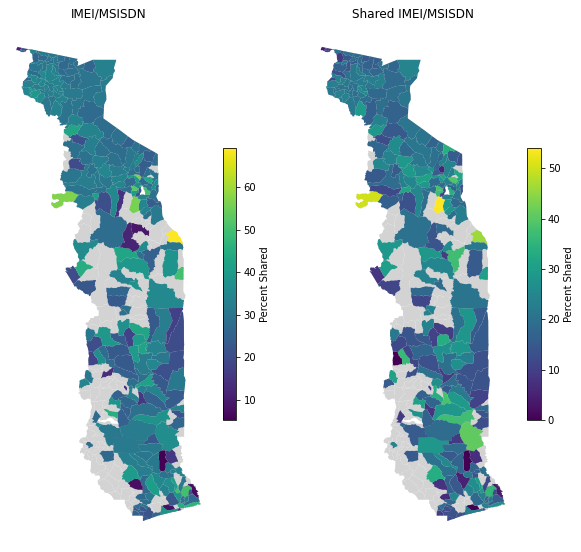

In [85]:
pop = data.groupby(['Prefecture', 'Canton'], as_index=False).agg('count')[['Prefecture', 'Canton', 'Gender']]\
    .rename({'Gender':'count'}, axis=1)
pop = pop[pop['count'] > 10]

avg = data.groupby(['Prefecture', 'Canton'], as_index=False).agg('mean')
avg = pop.merge(avg, on=['Prefecture', 'Canton'])

shapefile = gpd.read_file('/home/em/covid/spatial/cantons.geojson')[['Id', 'geometry']]\
    .rename({'Id':'shapefile_canton_id'}, axis=1)
merger = gpd.read_file('/data/togo_anon/satellite/selected_cantons_next100.csv')\
    [['shapefile_canton_id', 'novissi_canton_name', 'novissi_prefecture_name']]\
    .rename({'novissi_canton_name':'Canton', 'novissi_prefecture_name':'Prefecture'}, axis=1)
merger['shapefile_canton_id'] = merger['shapefile_canton_id'].astype('int')
shapefile = shapefile.merge(merger, on='shapefile_canton_id')
avg = shapefile.merge(avg, on=['Canton', 'Prefecture'], how='inner')

sns.reset_orig()
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
shapefile.plot(ax=ax[0], color='lightgrey')
avg.plot(ax=ax[0], column=['imei_per_msisdn'], legend=True, legend_kwds={'label': 'Percent Shared', 'shrink':0.5})
shapefile.plot(ax=ax[1], color='lightgrey')
avg.plot(ax=ax[1], column=['shared_imei_per_msisdn'], legend=True, 
         legend_kwds={'label': 'Percent Shared', 'shrink':0.5})
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('IMEI/MSISDN')
ax[1].set_title('Shared IMEI/MSISDN')
plt.savefig('/home/em/sharing2.png', dpi=300)
plt.show()

### Heterogeneity

In [106]:
import statsmodels.api as sm

data = df[['imei_per_msisdn', 'shared_imei_per_msisdn', 'treated', 'count_txns', 
           'Gender', 'Age', 'rural']]\
    .dropna()

data['imei_per_msisdn'] = (data['imei_per_msisdn'] > 1).astype('int')
data['shared_imei_per_msisdn'] = (data['shared_imei_per_msisdn'] > 0).astype('int')

data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'F' else 0)
#data['Age: 18-30'] = data['Age'].apply(lambda x: x <= 30).astype('int')
data['Age: 30-40'] = data['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
data['Age: 40-50'] = data['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
data['Age: 50+'] = data['Age'].apply(lambda x: x > 50).astype('int')

outcome = 'shared_imei_per_msisdn'
covariates = ['count_txns', 'treated', 'Gender', 'Age: 30-40', 'Age: 40-50', 
             'Age: 50+','rural']

y = data[outcome]
x = sm.add_constant(data[covariates].copy())
result = sm.OLS(y, x).fit()
print('%.4f' % result.rsquared)

0.0164


### Impacts of Novissi

In [134]:
data = df[df['targeted_canton'] == 1].copy()
data = data[['imei_per_msisdn', 'shared_imei_per_msisdn', 'treated', 'count_txns', 
           'Gender', 'Age', 'rural']].dropna()

data['imei_per_msisdn'] = (data['imei_per_msisdn'] > 1).astype('int')
data['shared_imei_per_msisdn'] = (data['shared_imei_per_msisdn'] > 0).astype('int')

data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'F' else 0)
#data['Age: 18-30'] = data['Age'].apply(lambda x: x <= 30).astype('int')
data['Age: 30-40'] = data['Age'].apply(lambda x: x > 30 and x <= 40).astype('int')
data['Age: 40-50'] = data['Age'].apply(lambda x: x > 40 and x <=50).astype('int')
data['Age: 50+'] = data['Age'].apply(lambda x: x > 50).astype('int')

data['GenderxTreated'] = data['Gender']*data['treated']
data['Age: 30-40xTreated'] = data['Age: 30-40']*data['treated']
data['Age: 40-50xTreated'] = data['Age: 40-50']*data['treated']
data['Age: 50+xTreated'] = data['Age: 50+']*data['treated']

outcome = 'imei_per_msisdn'
covariates = ['treated', 'count_txns', 'Age: 30-40', 'Age: 40-50', 'Age: 50+', 'Age: 30-40xTreated', 
              'Age: 40-50xTreated', 'Age: 50+xTreated']

y = data[outcome]
x = sm.add_constant(data[covariates].copy())
result = sm.OLS(y, x).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        imei_per_msisdn   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     148.8
Date:                Mon, 27 Sep 2021   Prob (F-statistic):          2.70e-248
Time:                        18:58:41   Log-Likelihood:                -26693.
No. Observations:               43631   AIC:                         5.340e+04
Df Residuals:                   43622   BIC:                         5.348e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2906      0

### Dif-in-dif

In [3]:
df = novissi.copy()

for month in ['october', 'november', 'december', 'january']:
    toplevel_dir = '/data/togo_anon/feats/phone_sharing/' + month

    imei_per_msisdn = pd.read_csv(toplevel_dir + 'imei_per_msisdn.csv')
    msisdn_per_imei = pd.read_csv(toplevel_dir + 'msisdn_per_imei.csv')
    shared_imei_per_msisdn = pd.read_csv(toplevel_dir + 'shared_imei_per_msisdn.csv')
    outcomes = [('imei_per_msisdn', imei_per_msisdn), 
                ('msisdn_per_imei', msisdn_per_imei), 
                ('shared_imei_per_msisdn', shared_imei_per_msisdn)]

    for label, outcome in outcomes:
        if label != 'msisdn_per_imei':
            data = outcome.rename({'caller_msisdn':'PhoneNumber', 'count':label + '_' + month}, axis=1)
            df = df.merge(data, on='PhoneNumber', how='left')
        
    counts = pd.read_csv(toplevel_dir + 'count_transactions.csv')\
        .rename({'caller_msisdn':'PhoneNumber', 'count':'count_txns_' + month}, axis=1)
    df = df.merge(counts, on='PhoneNumber', how='left')
    
df = df[(df['below_wealth_threshold'] == 1) & (df['targeted_canton'] == 1)]

/home/em/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = df[['PhoneNumber', 'treated', 'registered_nov'] + [col for col in df.columns if 'count' in col]\
          + [col for col in df.columns if 'imei' in col]]

october = data[['PhoneNumber', 'treated', 'registered_nov'] + \
               [col for col in data.columns if 'october' in col]].copy()
october['month'] = 10
october['treatmentxmonth'] = 0
october = october.drop('registered_nov', axis=1)
october.columns = ['PhoneNumber', 'treated', 'count_txns', 'imei_per_msisdn', 'shared_imei_per_msisdn', 'month',
                  'treatmentxmonth']

november = data[['PhoneNumber', 'treated', 'registered_nov'] + \
                [col for col in data.columns if 'november' in col]].copy()
november['month'] = 11
november['treatmentxmonth'] = november['registered_nov']
november = november.drop('registered_nov', axis=1)
november.columns = ['PhoneNumber', 'treated', 'count_txns', 'imei_per_msisdn', 'shared_imei_per_msisdn', 'month',
                  'treatmentxmonth']

december = data[['PhoneNumber', 'treated', 'registered_nov'] + \
                [col for col in data.columns if 'december' in col]].copy()
december['month'] = 12
december['treated'] = 1
december['treatmentxmonth'] = december['treated']
december = december.drop('registered_nov', axis=1)
december.columns = ['PhoneNumber', 'treated', 'count_txns', 'imei_per_msisdn', 'shared_imei_per_msisdn', 'month',
                  'treatmentxmonth']

january = data[['PhoneNumber', 'treated', 'registered_nov'] + \
               [col for col in data.columns if 'january' in col]].copy()
january['month'] = 1
january['treatmentxmonth'] = january['treated']
january = january.drop('registered_nov', axis=1)
january.columns = ['PhoneNumber', 'treated', 'count_txns', 'imei_per_msisdn', 'shared_imei_per_msisdn', 'month',
                  'treatmentxmonth']

data = pd.concat([october, november, december, january])

data['imei_per_msisdn'] = data['imei_per_msisdn'].apply(lambda x: np.nan if pd.isnull(x) else 1 if x > 1 else 0)
data['shared_imei_per_msisdn'] = data['shared_imei_per_msisdn'].apply(lambda x: np.nan if pd.isnull(x) else \
                                                                      1 if x > 0 else 0)

data['month_dummy'] = data['month']
data = data.set_index(['PhoneNumber', 'month'])
data = pd.get_dummies(data, columns=['month_dummy'], drop_first=False)
data = data.drop('month_dummy_10', axis=1)
data.head()

,,treated,count_txns,imei_per_msisdn,shared_imei_per_msisdn,treatmentxmonth,month_dummy_1,month_dummy_11,month_dummy_12
PhoneNumber,month,,,,,,,,
Al2MmQ4gDAMraQgL,10,0.0,8.0,0.0,0.0,0.0,0,0,0
WZN8rZk0v3pmvnb7,10,1.0,56.0,0.0,0.0,0.0,0,0,0
5KowryQZb38rYReA,10,0.0,129.0,1.0,0.0,0.0,0,0,0
d9wzGl5o8pRqxe5R,10,0.0,138.0,1.0,0.0,0.0,0,0,0
WaN2qVb3gJ4qkdxJ,10,1.0,135.0,0.0,0.0,0.0,0,0,0


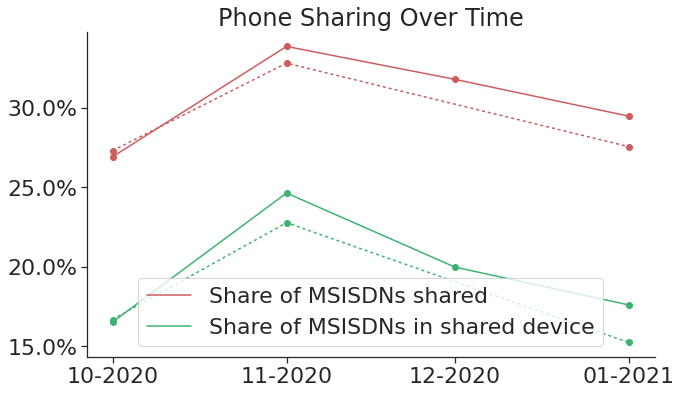

,month_date,treated,imei_per_msisdn,shared_imei_per_msisdn
0,2020-10-01,0.0,0.273034,0.166924
1,2020-10-01,1.0,0.269214,0.165333
2,2020-11-01,0.0,0.328099,0.227789
3,2020-11-01,1.0,0.338593,0.246422
4,2020-12-01,1.0,0.317898,0.199879


In [9]:
timeseries = data.copy()
timeseries['month_int'] = [x[1] for x in timeseries.index]
timeseries['month_date'] = timeseries['month_int'].apply(lambda x: '2020-10' if x == 10
                                                        else '2020-11' if x == 11
                                                        else '2020-12' if x == 12
                                                        else '2021-01')
timeseries['month_date'] = pd.to_datetime(timeseries['month_date'])
timeseries = timeseries[['month_date', 'imei_per_msisdn', 'shared_imei_per_msisdn', 'treated']].dropna()
avg = timeseries.groupby(['month_date', 'treated'], as_index=False).agg('mean')
treated = avg[avg['treated'] == 1]
untreated = avg[avg['treated'] == 0]
#counts = timeseries.groupby('month_date', as_index=False).agg('count')\
#    [['month_date', 'imei_per_msisdn']]\
#    .rename({'imei_per_msisdn':'count'}, axis=1)
#timeseries = avg.merge(counts, on='month_date', how='inner')

fig, ax = plt.subplots(1, figsize=(10, 6))

ax.plot(treated['month_date'], 100*treated['imei_per_msisdn'], label='Share of MSISDNs shared', 
       color='indianred')
ax.scatter(treated['month_date'], 100*treated['imei_per_msisdn'], color='indianred')
ax.plot(untreated['month_date'], 100*untreated['imei_per_msisdn'], 
        color='indianred', dashes=[2, 2])
ax.scatter(untreated['month_date'], 100*untreated['imei_per_msisdn'], color='indianred')

ax.plot(treated['month_date'], 100*treated['shared_imei_per_msisdn'], 
        label='Share of MSISDNs in shared device', color='mediumseagreen')
ax.scatter(treated['month_date'], 100*treated['shared_imei_per_msisdn'], color='mediumseagreen')
ax.plot(untreated['month_date'], 100*untreated['shared_imei_per_msisdn'], color='mediumseagreen', dashes=[2, 2])
ax.scatter(untreated['month_date'], 100*untreated['shared_imei_per_msisdn'], color='mediumseagreen')


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_title('Phone Sharing Over Time')
ax.legend(loc='best')
simpleaxis(ax)
plt.tight_layout()
plt.savefig('/home/em/phoneshare.png', dpi=300)
plt.show()

avg.head()

In [81]:
from linearmodels.panel import PanelOLS

exog_vars = ['treated', 'treatmentxmonth', 'count_txns', 'month_dummy_11', 'month_dummy_12', 'month_dummy_1']
exog = sm.add_constant(data[exog_vars])
outcome = 'imei_per_msisdn'

mod = PanelOLS(data[outcome], exog, entity_effects=True, time_effects=False)
result = mod.fit()
print(result)

                          PanelOLS Estimation Summary                           
Dep. Variable:        imei_per_msisdn   R-squared:                        0.0117
Estimator:                   PanelOLS   R-squared (Between):              0.0354
No. Observations:              174455   R-squared (Within):               0.0117
Date:                Mon, Sep 27 2021   R-squared (Overall):              0.0215
Time:                        22:18:38   Log-likelihood                -6.014e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      249.05
Entities:                       48490   P-value                           0.0000
Avg Obs:                       3.5978   Distribution:                F(6,125959)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             249.05
                            

In [15]:
data[outcome].values

array([0, 0, 1, ..., 0, 0, 0])